### Sentiment Analysis for Valuable Text Extraction Using ProsusAI/finbert model (Hugging Face)

Done by Anood

#### Importing libraries

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import pdfplumber
import regex as re
import matplotlib.pyplot as plt
import json

#### Importing the pre-trained sentiment analysis model

In [1]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

nlp = pipeline("sentiment-analysis", model = model, tokenizer=tokenizer)

2023-02-17 15:32:09.571287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Testing pre-trained model on a sample text

In [3]:
test = "Specifically, both security and engineering personnel feel that some types of concerns are not being addressed and expressed concern in management’s decision making associated with correcting some types of issues, including some safety related conditions."
nlp(test)[0]

{'label': 'negative', 'score': 0.9302244782447815}

#### PDF parsing and tokenization into sentences

In [4]:
all_sentences = []
with pdfplumber.open(r'DCISC-24th-Annual-Report.pdf') as pdf:
    page_numbers = len(pdf.pages)
    for num in range(page_numbers):
        page = pdf.pages[num]
        page_text = page.extract_text()
        page_text = page_text.replace('\n'," ")
        page_sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', page_text)
        all_sentences.append(page_sentences)

#### Running the model on the entire report and outputting negative sentences with at least 90% confidence

In [5]:
neg_sentences_bert = []
count = 0
for page_sentences in all_sentences:
    count+=1
    for text in page_sentences:
        try:
            prediction = nlp(text)
        except:
            continue
        label = prediction[0]['label']
        score = prediction[0]['score']
        if (label == 'negative') and (score >= 0.90):
            neg_sentences_bert.append({'sentence':text,'page':count,'label':label,'confidence':score})

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


In [6]:
neg_sentences_bert

[{'sentence': 'DCPP acted prompt with corrective actions and submitted a Licensee Event Report when it discovered Technical Specification non-compliance on the Low Temperature Overpressure Protection System.',
  'page': 7,
  'label': 'negative',
  'confidence': 0.9179659485816956},
 {'sentence': 'of power to Unit 2 4kV Bus G during Refueling Outage 2R17 was avoidable and was due to a number of breakdowns in the planning and conduct of a maintenance activity during the refueling outage.',
  'page': 8,
  'label': 'negative',
  'confidence': 0.9637327194213867},
 {'sentence': 'Three Station Level Human Performance Event Clock Resets occurred during the fourth quarter of 2013, causing the station’s 18-month indicator for such Resets to become Yellow (deficient).',
  'page': 8,
  'label': 'negative',
  'confidence': 0.9597238302230835},
 {'sentence': 'Operations performance with respect to human error rate has been Red (Unsatisfactory) since July 2013.',
  'page': 8,
  'label': 'negative',


#### Visualization of proportion of extracted sentences and total number of sentences

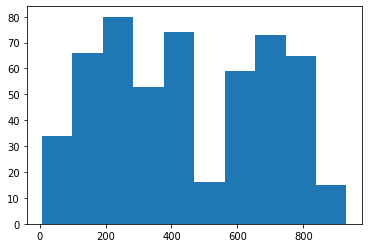

Number of 'negative' texts to be further analyzed: 535


In [8]:
page_numbers = []
for item in neg_sentences_bert:
    page_numbers.append(item['page'])
plt.hist(page_numbers)
plt.show()
print("Number of 'negative' texts to be further analyzed:", len(page_numbers))

#### Saving the extracted sentences as JSON file to be used in Aspects Extraction

In [10]:
with open('extracted_sentences.json', 'w') as fout:
    json.dump(neg_sentences_bert, fout)